In [6]:
import os
import matplotlib.pyplot as plt
import sys
import torch
import numpy as np
import time
from tqdm import tqdm
import pickle
import warnings

warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path) 
from utils import *
import ResNet as net
criterion = torch.nn.MSELoss(reduction='none')

In [7]:
# adjustables
k = list(range(11))            # model index: should be in {0, 2, ..., 10}
dt = 0.01  # time unit: 0.0005 for Lorenz and 0.01 for others
model_prefix='KS'
system = 'KS'         # system name: ""FHN","KS,'RD'
noise = 0.0                    #noise levels: 0.0, 0.01, 0.02, 0.05 ,0.1, 0.2

lr = 1e-3                     # learning rate
max_epoch = 10000            # the maximum training epoch
            # training batch size
# arch = [200, 128, 64,4, 128,64, 200]  # architecture of the neural network (check paper for details)

In [8]:
# paths
data_dir = os.path.join('../data/', system)
model_dir = os.path.join('../models/', system)
path_to_result=os.path.join('../results/', system)
path=os.path.join('../results/KS/data', system)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
# global const
n_forward = 5

In [9]:
train_data = torch.load(data_dir + "/train_data.pt")
val_data = torch.load(data_dir + "/val_data.pt")
test_data = torch.load(data_dir + "/test_data.pt")
n=train_data.shape[2]

t_test=train_data.shape[1]
val_data=val_data[:,:t_test,:]

test_data=test_data[:,:t_test,:]
T1=train_data.shape[1]
T2=2*T1
T3=3*T1
T5=5*T1
T7=7*T1
T10=10*T1
train_data.shape,test_data.shape,val_data.shape

(torch.Size([200, 5121, 120]),
 torch.Size([5, 5121, 120]),
 torch.Size([5, 5121, 120]))

In [10]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]
batch_size = n_train 

In [11]:
train_data=torch.tensor(train_data)
train_data = train_data.to(torch.float32).to(device)

### Training HiTS

In [15]:
### one set training 
# dummy parameter
z_train1=train_data[:10,:,:]
set=z_train1.shape[0]
data=z_train1#.reshape(z_train1.shape[0]*z_train1.shape[1],z_train1.shape[2])
data=data.cpu().detach().numpy()
batch_size=32
models = list()
L1=128
L2=256
L3=512
L4=1024
L5=2048
z=data.shape[2]
dt = 1
n_forward=5
step_sizes=[1,2,4,8,16,32,64,128,256,512,1024]
# training
max_epoch=20000
start=time.time()
n_steps = data.shape[1] - 1  # number of forward steps
for step_size in step_sizes:
    resdata = np.empty((0, step_size * n_forward + 1, z_train1.shape[2]))
    for j in range(set):
        data=z_train1[j,:,:].cpu().detach().numpy()
        m = int(np.ceil(n_steps/(step_size*n_forward)))
        pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
        for i in range(m):
            start_idx = i*step_size*n_forward
            end_idx = start_idx + step_size*n_forward + 1
            tmp = data[start_idx:end_idx, :]
            pdata[i, :tmp.shape[0], :] = tmp
        resdata = np.concatenate((resdata, pdata), axis=0)
    pdata=resdata
    dataset = net.DataSet(pdata, pdata, data[np.newaxis, :], dt, step_size, n_forward)
    model_name = 'hitsmodeltest_D{}.pt'.format(step_size)
    print('MODEL: '+model_prefix+'_D{}'.format(step_size))
    model = net.ResNet(arch=[z,L4,L4,L4,z], dt=dt, step_size=step_size)
    # model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr, model_path=os.path.join(model_dir, model_name))
    # models.append(model)
end=time.time()
train_time=end-start
print(train_time)
print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

MODEL: KS_D1
MODEL: KS_D2
MODEL: KS_D4
MODEL: KS_D8
MODEL: KS_D16
MODEL: KS_D32
MODEL: KS_D64
MODEL: KS_D128
MODEL: KS_D256
MODEL: KS_D512
MODEL: KS_D1024
1.3044891357421875
# of params:  0


In [8]:
z_train=train_data
z_valid=torch.tensor(val_data[:,:t_test,:]).to(device)
z_test=torch.tensor(test_data[:,:t_test,:]).to(device)

In [11]:
tspan=z_train.shape[1]#### Hits training]
np.random.seed(2)  # for reproduction
dt = 0.01  #0.001
train_steps = tspan  # at least equal to the largest step size
val_steps =tspan
test_steps = tspan  # t=20
t = np.linspace(0, (train_steps-1)*dt, train_steps)

In [12]:
#a=np.array([1,8,64,128,256,512,1024,2048,10240,20480,40960])
# load the data to dataset object
dt=0.01
datasets = list()
step_sizes = list()
print('Dt\'s: ')
#a=[10,20,30,60,100,200,400,600,800]
for i in range(11):
    step_size = 2**i  #exponential function
    print(step_size)
    print(step_size * dt)
    step_sizes.append(step_size)
    datasets.append(DataSet(z_train, z_valid, z_test, dt, step_size=step_size, n_forward=5))

Dt's: 
1
0.01
2
0.02
4
0.04
8
0.08
16
0.16
32
0.32
64
0.64
128
1.28
256
2.56
512
5.12
1024
10.24


In [1]:
### load models on CPU
# # load models
# models = list()
# for step_size in step_sizes:
#     print('load model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'hitsmodeltest_D{}.pt'.format(step_size)), map_location='cpu'))

# # fix model consistencies trained on gpus (optional)
# for model in models:
#     model.device = 'cpu'
#     model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [16]:
### load models on GPU
# step_sizes=[1]
noise=0.0
models = list()
for step_size in step_sizes:
    print('loading model_D{}.pt'.format(step_size,))
    models.append(torch.load(os.path.join(model_dir, 'hitsmodeltest_D{}.pt'.format(step_size)))) ## keep model name same as trained

loading model_D1.pt
loading model_D2.pt
loading model_D4.pt
loading model_D8.pt
loading model_D16.pt
loading model_D32.pt
loading model_D64.pt
loading model_D128.pt
loading model_D256.pt
loading model_D512.pt
loading model_D1024.pt


In [18]:
# n_steps

In [19]:
n_steps =z_test.shape[1] - 1
n_steps_val=val_data.shape[1] - 1
preds_mse = list()
times = list()
z_hits_uni=[]
print('uniscale forecasting...')
for model in models:
    start = time.time()
    z_RN = model.uni_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps).to(device)
    z_hits_uni.append(z_RN)
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(z_test[:, 1:, :]).float(), z_RN).mean(-1))
print('prediction recorded!')

uniscale forecasting...
prediction recorded!


100%|██████████| 9/9 [00:00<00:00, 10.99it/s]


use models 4 - 9.
online time elaspsed is 20.583728075027466


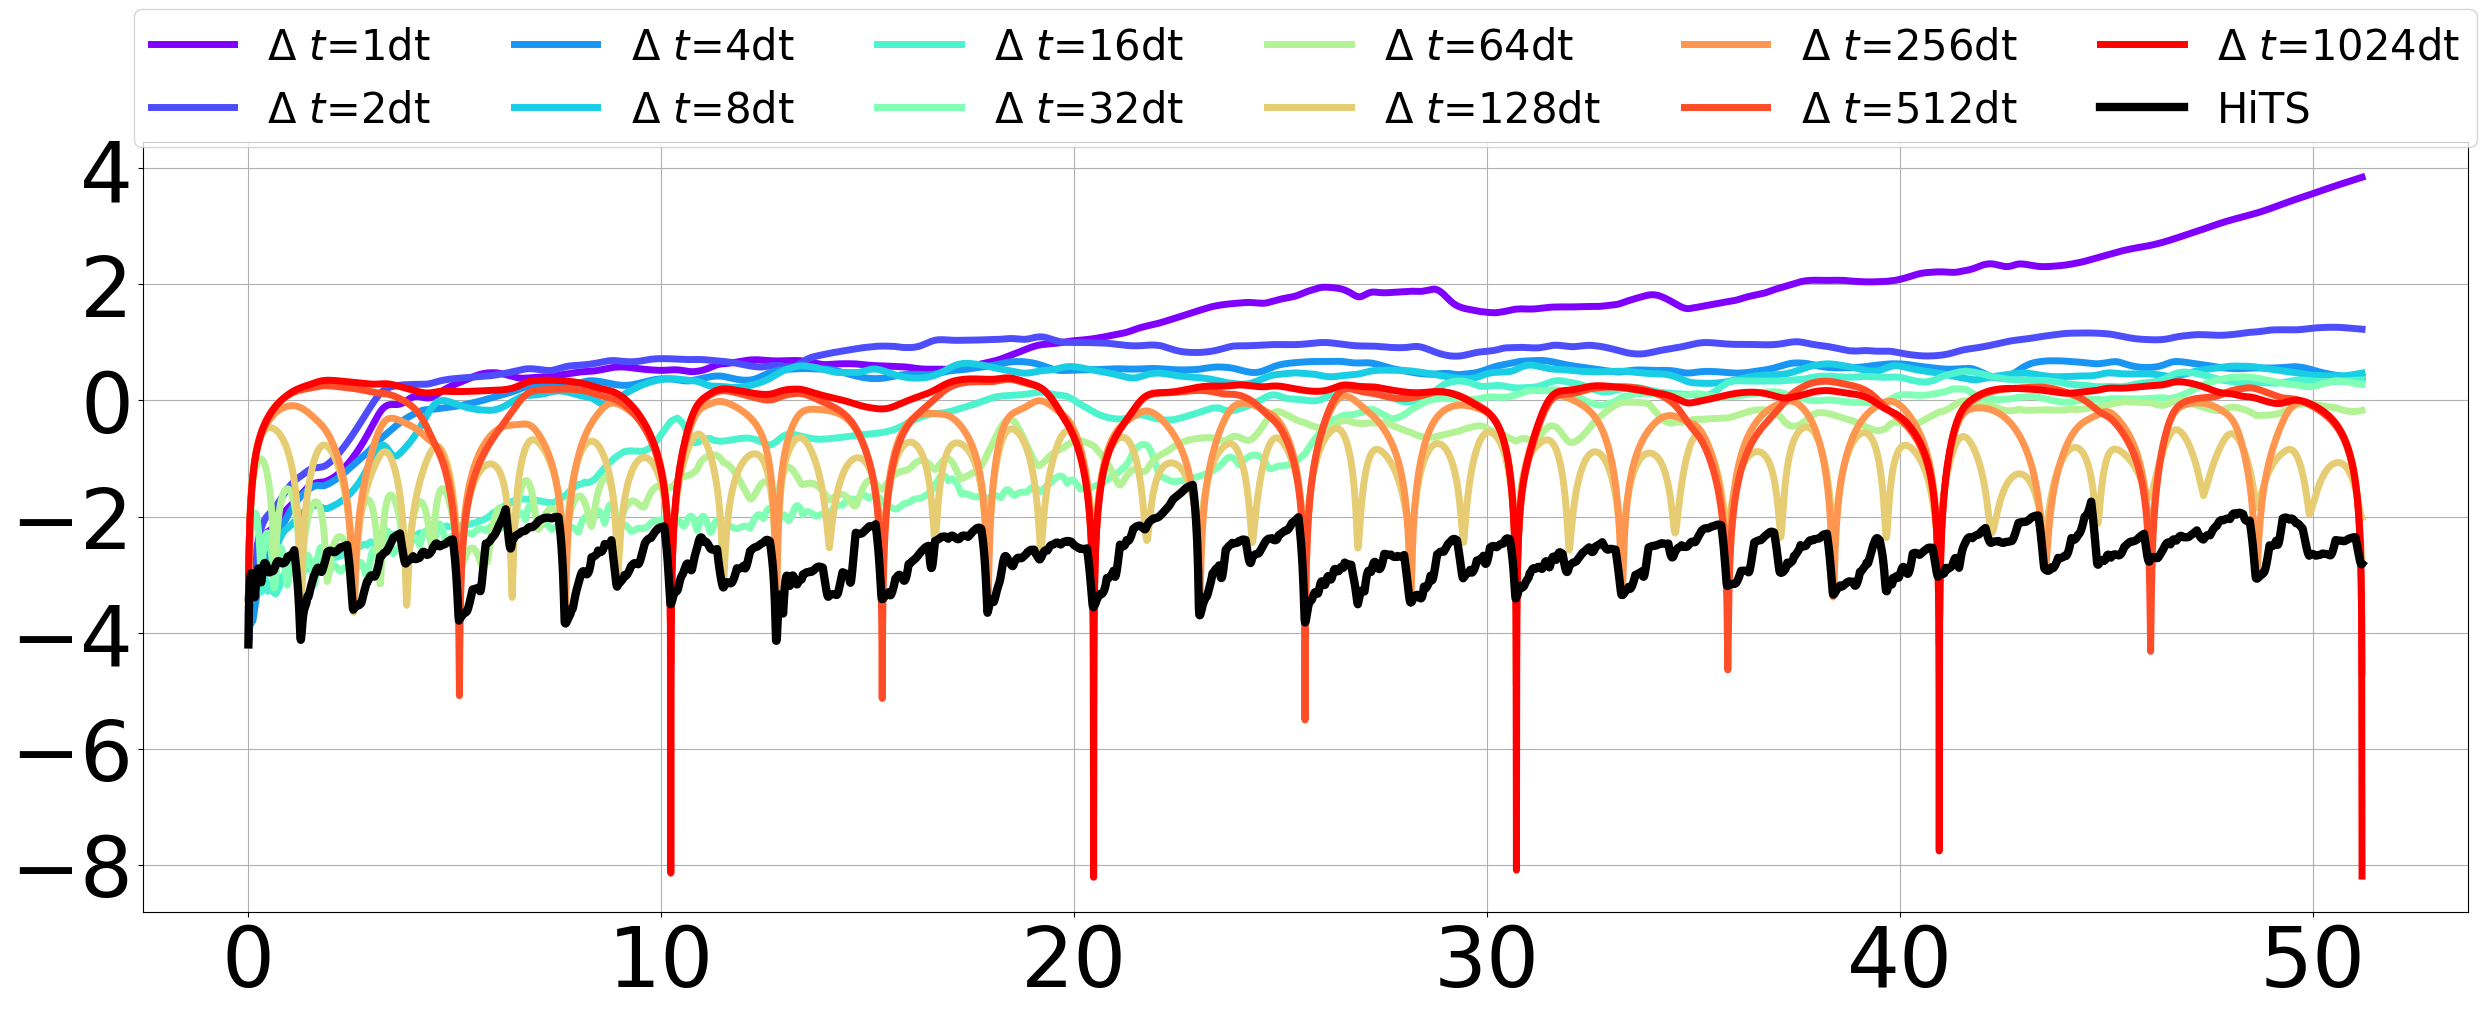

In [23]:
# model selections 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5  #1e+5
start_time = time.time()
# choose the largest time step
for i in tqdm(range(len(models))):
    z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[:len(models)-i]).to(device)
    mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

# choose the smallest time step
for i in tqdm(range(end_idx)):
    z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_valid[:, 0, :]).float(), n_steps=n_steps_val, models=models[i:end_idx]).to(device)
    mse = criterion(torch.tensor(z_valid[:, 1:, :]).float(), z_hits).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models1 = models[start_idx:end_idx]
# models1 = models
# models1=[models[i] for i in [4,5,7,9,10]]
# multiscale time-stepping with NN

z_hits = net.vectorized_multi_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps, models=models1).to(device)
end_time = time.time()
hits_time=end_time-start_time
print('online time elaspsed is',hits_time)
multiscale_preds_mse = criterion(torch.tensor(z_test[:, 1:, :]).float(), z_hits).mean(-1)
multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
t = np.linspace(0, (n_steps-1)*dt, n_steps)
# visualize forecasting error at each time step    
norm_uni=list()
nnerr=[]
ks = list(range(11))
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
mean_pointwise=list()
multiscale_err = multiscale_preds_mse.mean(0).cpu().detach().numpy()
#Figure1: error plot
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).cpu().detach().numpy()
    nnerr.append(mean)
    norm_uni.append(mean.mean())  #mean
    mean_pointwise.append(mean)
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid()
plt.show()

In [24]:
MSE_HITS=multiscale_err
mse_hits=multiscale_err.mean()
print(mse_hits)

0.00321639


In [88]:
path

'../results/KS/data/KS'

### Save results in figure

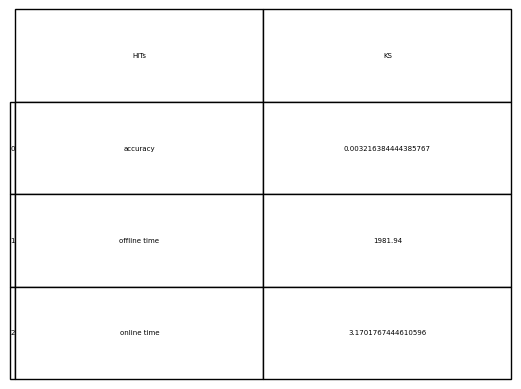

<Figure size 640x480 with 0 Axes>

In [30]:
# import pandas as pd
# # Create a dictionary with variable names as keys and values as entries
# datatable = {
#     'HITs': ['accuracy', 'offline time', 'online time'],
#     'KS': [mse_hits,train_time,hits_time]
# }

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(datatable)

# # Create a table plot using pandas
# table = pd.plotting.table(
#     ax=plt.gca(),
#     data=df,
#     loc='center',
#     cellLoc='center',
#     colWidths=[0.2, 0.2],
#     bbox=[0, 0, 1, 1]
# )

# # Customize the table appearance
# table.set_fontsize(14)
# table.scale(1.2, 1.2)

# # Remove the axis labels and ticks
# plt.axis('off')

# # Save the figure
# tablename='cpuAcc_hits.png'
# plt.show()
# plt.savefig(path+tablename, bbox_inches='tight')